In [1]:
# import libraray 

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD


# BUSINESS UNDERSTANDING :

Objectives :-The objective of this recommendation system implementation is to enhance the user experience on the e-commerce site by providing personalized product recommendations. Specifically, we aim to leverage item-based collaborative filtering to achieve a significant improvement in key performance indicators.

Target Improvement :- Our target is to realize a 15% increase in user engagement or a 10% increase in conversion rates, thereby saving consumer time and contributing to the overall success of the client's business.

# DATA UNDERSTANDING

The dataset consists of three files: a file with behaviour data (events.csv), a file with item properties (item_properties.сsv) and a file, which describes category tree (category_tree.сsv). The data has been collected from a real-world ecommerce website we will use file with behaviour data (events.csv) because we will performe collaborative filtering so there is only columns need is user and items and there interaction value which available in events data iteslf, so we will ignore rest file

In [2]:
# read the data
df  = pd.read_csv("/kaggle/input/ecommerce-dataset/events.csv")
df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [3]:
# check how many columns , rows and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [4]:
df = df.sort_values(by=['visitorid', 'timestamp']).reset_index(drop=True)
df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1442004589439,0,view,285930,NaN
1,1442004759591,0,view,357564,NaN
2,1442004917175,0,view,67045,NaN
3,1439487966444,1,view,72028,NaN
4,1438969904567,2,view,325215,NaN


In [5]:
uniq_visitor = df['visitorid'].nunique()
total_visitor = df['visitorid'].size

print(f'Total visitor:{total_visitor}')
print(f'Unique visitor:{uniq_visitor}')

Total visitor:2756101
Unique visitor:1407580


In [6]:
df.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

In [7]:
item_purchased = df[df["transactionid"].notnull()].visitorid.nunique()
item_purchased

11719

In [8]:
df.duplicated().sum()

460

In [9]:
#drop duplicates
df.drop_duplicates(keep= "first", inplace=True)

In [10]:
event_count = df["event"].value_counts()
event_count

event
view           2664218
addtocart        68966
transaction      22457
Name: count, dtype: int64

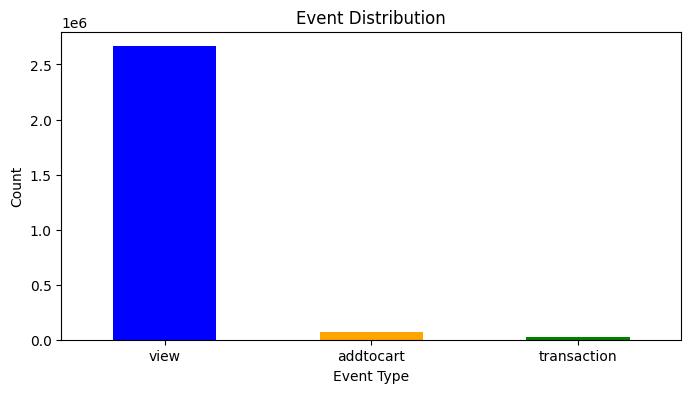

In [11]:
#visualizing event distribution

plt.figure(figsize=(8, 4))
df['event'].value_counts().plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Event Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

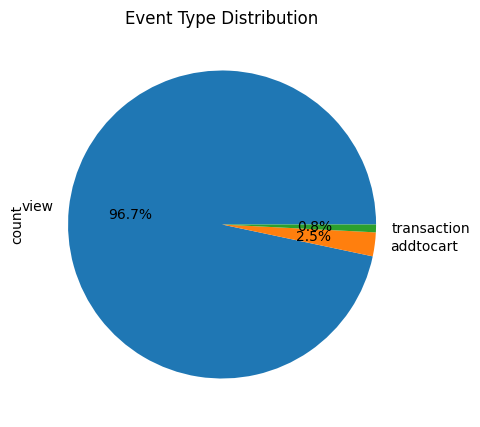

In [12]:
#percentage wise distribution showed 

event_percentage = event_count / len(df)
plt.figure(figsize=[5,5])
event_percentage.plot(kind='pie', autopct='%1.1f%%')
plt.title('Event Type Distribution')
plt.show()

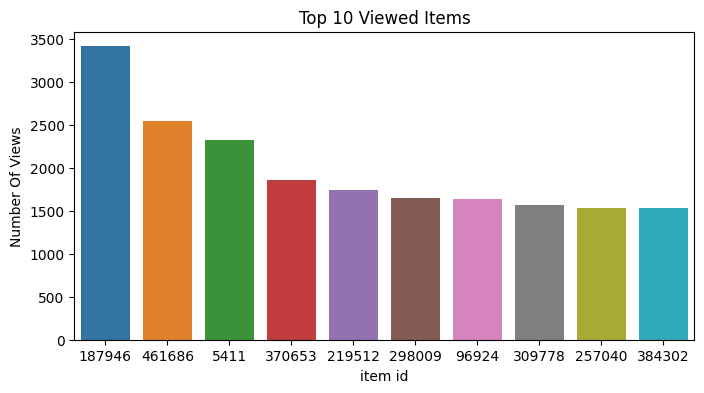

In [13]:
# top viewed items

top_viewed_items = df[df['event']=='view']['itemid'].value_counts().head(10)
top_viewed_items = top_viewed_items.sort_values(ascending= False)
plt.figure(figsize=(8,4))
sns.barplot(x=top_viewed_items.index, y=top_viewed_items.values, order = top_viewed_items.index)
plt.title('Top 10 Viewed Items')
plt.xlabel('item id')
plt.ylabel('Number Of Views')
plt.show()


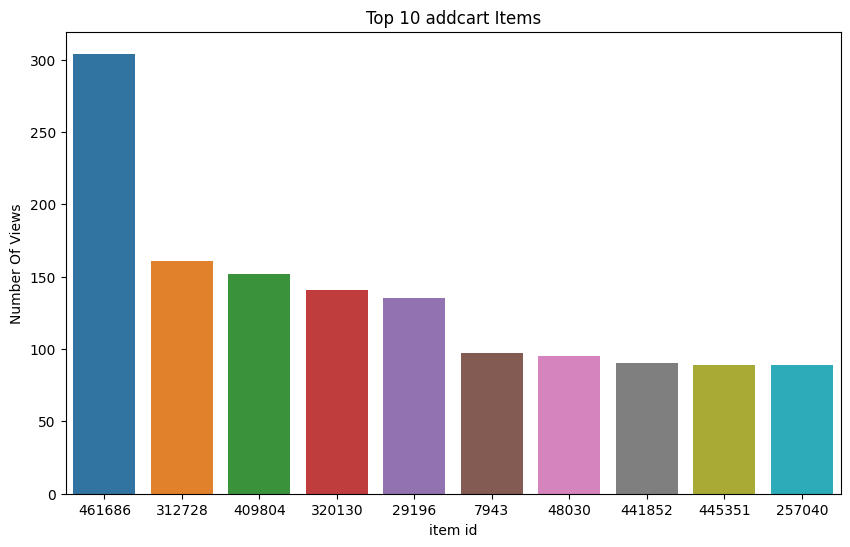

In [14]:
# top items added to cart

top_addcart_items = df[df['event']=='addtocart']['itemid'].value_counts().head(10)
top_addcart_items = top_addcart_items.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=top_addcart_items.index, y=top_addcart_items.values, order=top_addcart_items.index)
plt.title('Top 10 addcart Items')
plt.xlabel('item id')
plt.ylabel('Number Of Views')
plt.show()

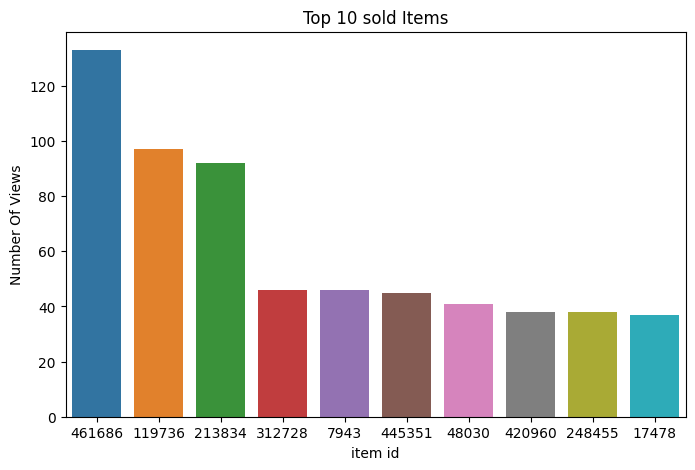

In [15]:
#top sold items 

top_sold_items = df[df['event']=='transaction']['itemid'].value_counts().head(10)
top_sold_items = top_sold_items.sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=top_sold_items.index, y=top_sold_items.values, order=top_sold_items.index)
plt.title('Top 10 sold Items')
plt.xlabel('item id')
plt.ylabel('Number Of Views')
plt.show()

# Collaborative Filtering : Item - Based

**We want to suggest the User a item, that may be added to the cart. Based on item based collaborative filtering.**

In [16]:
visitor_item_event_df = df.groupby(["visitorid","itemid","event"])["timestamp"].count().to_frame().reset_index()
visitor_item_event_df

,visitorid,itemid,event,timestamp
0,0,67045,view,1
1,0,285930,view,1
2,0,357564,view,1
3,1,72028,view,1
4,2,216305,view,2
...,...,...,...,...
2215417,1407575,121220,view,1
2215418,1407576,356208,view,1
2215419,1407577,427784,view,1
2215420,1407578,188736,view,1


In [17]:
np.random.seed(1)
items_to_keep = np.random.choice(visitor_item_event_df['itemid'].unique(), size=100000, replace=False)
visitor_item_event_df = visitor_item_event_df[visitor_item_event_df['itemid'].isin(items_to_keep)]

In [18]:
#lets get addtocart event only

visitor_item_df = visitor_item_event_df[visitor_item_event_df['event'] == 'addtocart']
visitor_item_df.head()

,visitorid,itemid,event,timestamp
207,155,41882,addtocart,1
213,155,181405,addtocart,1
215,155,368372,addtocart,1
217,155,389974,addtocart,1
379,264,161949,addtocart,1


**CREATE METRICS**

In [19]:
#convert long data into wide range for details of user based colaborative 

item_wise_df = visitor_item_df.pivot(index='itemid', columns='visitorid', values='timestamp')
item_wise_df


visitorid,155,264,419,420,539,588,627,648,795,878,...,1407037,1407059,1407064,1407070,1407110,1407129,1407355,1407430,1407512,1407515
itemid,,,,,,,,,,,,,,,,,,,,,
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
466685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
466688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***AS WE SEE LOT OF NAN VALUE AVAILBLE IN OUR DATASET SO TO NORMALIZE AND ADDRESSING SPARSITY FILLING MISSING VALUE WITH NEUTRAL SCORES BY PERFORMING MEAN CENTERING***

# MEAN CENTERING

In [20]:
# subtracting the mean of the addtocart from each individual data point

avg_addcarts = item_wise_df.sum() / item_wise_df.shape[1]
visitor_item_raw_df  = item_wise_df.copy()
item_wise_df  = item_wise_df.sub(avg_addcarts , axis = 1)
item_wise_df = item_wise_df.fillna(0)
item_wise_df.head()


visitorid,155,264,419,420,539,588,627,648,795,878,...,1407037,1407059,1407064,1407070,1407110,1407129,1407355,1407430,1407512,1407515
itemid,,,,,,,,,,,,,,,,,,,,,
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
#we addressed that our data has sparsity so calculating sparsity percentage

not_empty = visitor_item_raw_df.notnull().values.sum()
total_number = visitor_item_raw_df.size
print(100 * not_empty/total_number)

0.014052655828659695


**This suggests that 99.86% of the entries in our DataFrame are empty**

# MATRIX FACTORIZATION:

In [22]:
# Convert DataFrame to Sparse Matrix

item_wise_sparse = csr_matrix(item_wise_df) 
U, sigma, Vt = svds(item_wise_sparse)

In [23]:
#multiply decompose matrixes to get filled matrix

filled_matrix = np.dot(np.dot(U, np.diag(sigma)), Vt)
filled_matrix = filled_matrix + avg_addcarts.values.reshape(1, -1)
pd.DataFrame(filled_matrix,
            index=visitor_item_raw_df.index,
            columns=visitor_item_raw_df.columns)

visitorid,155,264,419,420,539,588,627,648,795,878,...,1407037,1407059,1407064,1407070,1407110,1407129,1407355,1407430,1407512,1407515
itemid,,,,,,,,,,,,,,,,,,,,,
25,0.000213,0.000107,0.000053,0.000213,0.000107,0.000053,0.000053,0.000053,0.000053,0.000053,...,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000213,0.000053
33,0.000213,0.000107,0.000053,0.000213,0.000107,0.000053,0.000053,0.000053,0.000053,0.000053,...,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000213,0.000053
66,0.000213,0.000107,0.000053,0.000213,0.000107,0.000053,0.000053,0.000053,0.000053,0.000053,...,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000213,0.000053
168,0.000213,0.000107,0.000053,0.000214,0.000131,0.000053,0.000053,0.000054,0.000077,0.000098,...,0.000058,0.000053,0.000062,0.000087,0.000077,0.000132,0.000053,0.000230,0.000213,0.000053
212,0.000213,0.000107,0.000053,0.000213,0.000107,0.000053,0.000053,0.000053,0.000053,0.000054,...,0.000053,0.000053,0.000053,0.000054,0.000053,0.000053,0.000053,0.000054,0.000213,0.000053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466614,0.000213,0.000107,0.000053,0.000213,0.000115,0.000053,0.000053,0.000054,0.000058,0.000081,...,0.000055,0.000053,0.000053,0.000066,0.000059,0.000035,0.000053,0.000149,0.000213,0.000053
466685,0.000213,0.000107,0.000053,0.000213,0.000107,0.000053,0.000053,0.000053,0.000053,0.000060,...,0.000053,0.000053,0.000053,0.000054,0.000054,0.000051,0.000053,0.000069,0.000213,0.000053
466688,0.000213,0.000107,0.000053,0.000213,0.000107,0.000053,0.000053,0.000053,0.000053,0.000053,...,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000213,0.000053


In [24]:
# Generate Train and Test Data using random sample

np.random.seed(42)
mask = np.random.choice([False, True], size=item_wise_df.shape, p=[0.2, 0.8])
train_data = np.where(mask, item_wise_sparse.A, 0)
test_data = np.where(~mask, item_wise_sparse.A, 0)

In [30]:
# Perform SVD on the training data

item_wise_sparse = csr_matrix(item_wise_df)

U, sigma, Vt = svds(train_data)

# Predict missing values using the dot product of left and right singular vectors
predicted_matrix = np.dot(U, np.dot(np.diag(sigma), Vt))
predicted_df = pd.DataFrame(predicted_matrix,
            index=item_wise_df.index,
            columns=item_wise_df.columns)

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between items
item_similarity = cosine_similarity(predicted_df)

# item_similarity is a square matrix where item_similarity[i, j] represents the cosine similarity between item i and item j.


In [54]:
# Function to get top N recommendations for a given user using item-item cosine similarity
user_id_to_index = {user_id: idx for idx, user_id in enumerate(item_wise_df.columns)}

import numpy as np

# Function to get top N recommendations for a given user using item-item cosine similarity
def get_top_user_recommendations(user_id, user_id_to_index, item_wise_df, item_similarity, N=10):
    # Get user index from user ID
    user_index = user_id_to_index[user_id]
    
    # Convert item-wise DataFrame to NumPy array
    item_wise_matrix = item_wise_df.values
    
    # Get user vector from item-wise matrix
    user_vector = item_wise_matrix[:, user_index]
    
    # Compute scores for all items by taking dot product with item similarity matrix
    item_scores = np.dot(item_similarity, user_vector)
    
    # Sort item indices based on scores (in descending order)
    top_item_indices = np.argsort(item_scores)[::-1]
    
    # Exclude items already interacted with by the user
    user_interacted_items = set(np.where(user_vector > 0)[0])
    top_unseen_item_indices = [idx for idx in top_item_indices if idx not in user_interacted_items]
    
    # Get top N recommendations
    top_N_recommendations = top_unseen_item_indices[:N]
    
    return top_N_recommendations

# Example: Get top 10 recommendations for user with ID 1407037
user_id = 1407037  # Change this to the desired user ID
top_N_user_recommendations = get_top_user_recommendations(user_id, user_id_to_index, item_wise_df, item_similarity, N=10)

# Print the top recommendations
print("Top 10 recommendations for user", user_id)
for i, item in enumerate(top_N_user_recommendations):
    print(f"{i+1}. Item ID: {item}")


Top 10 recommendations for user 1407037
1. Item ID: 6504
2. Item ID: 1343
3. Item ID: 9425
4. Item ID: 5342
5. Item ID: 1565
6. Item ID: 4124
7. Item ID: 5535
8. Item ID: 9596
9. Item ID: 8133
10. Item ID: 8611


In [26]:
Rmse = np.sqrt(mean_squared_error(test_data[test_data != 0], predicted_matrix[test_data != 0]))
print(Rmse)

1.1815408325797445


In [27]:
model = TruncatedSVD()
model.fit(train_data)

TruncatedSVD()